# Solving CartPole-v0 using Actor Critic

Cartpole is a classic control reinforcement learning problem where a pole is attached to a cart and can rotate about its joint. The goal is to keep it upright and prevent it from falling over by increasing or reducing cart's velocity. This noteboook will use OpenAI Gym's [CartPole-v0](https://github.com/openai/gym/wiki/CartPole-v0) environment to solve to problem. Refer the [documentation](https://gym.openai.com/docs/) to learn more about OpenAI Gym environments.

## Environment

An observation in CartPole-v0 is defined by 4 values - cart position, cart value, pole angle and pole velocity at the tip. Corresponding to every obeservation (except last where the episode ends), two actions discrete can be taken - push cart to the left or to the right. For every non terminal step a reward of +1 is obtained.




In [1]:
import os
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

env = gym.make("CartPole-v0")
env.reset()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


array([-0.02030492, -0.01113519, -0.01865397,  0.01060945])

## Policy Gradients

Policy gradient methods optimize the policy function which agent uses to pick actions. Our policy function will be a vanilla neural network, **Policy**, with a single hidden layer. Input to our policy network will be the observations of the environment at a certain step or a state and the output will be raw policy values correspoinding to every action. We'll apply a softmax fucntion later to these raw  policy values to get probabilities with with we'll select our action in that state. 

In [2]:
class Policy(nn.Module):
    """
    Create policy network which takes state featues as input and outputs unnormalized 
    action values.
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.num_actions = env.action_space.n
        self.state_dim = env.observation_space.shape[0]
        self.fc1 = nn.Linear(self.state_dim, 256)
        self.policy_head = nn.Linear(256, self.num_actions)
        self.value_head = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        policy_values = self.policy_head(x)
        state_value = self.value_head(x)
        return (policy_values, state_value)
    
restore_model = True
    
if restore_model and os.path.isfile("cartpole_policy_actor_critic.pt"):
    policy = torch.load("cartpole_policy_actor_critic.pt")
else:
    policy = Policy()
    
optimizer = optim.Adam(policy.parameters(), lr=0.001)

## Actor Critic loss function

We have to maximize expected rewards, $J(\theta)$, in the long run. We can formulate the problem as minimizing the negative of expected rewards.

$$\nabla_\theta J(\theta) = \nabla E_{\pi}\bigg[\sum_{t=1}^{T}G_t\nabla_\theta\log{\pi_\theta (a_t | s_t)} + (G_t - V(s_t))^2\bigg]$$

where,<br><br>

$J(\theta)$ : expected reward in an episode,<br>
$\theta$ : parameters of policy function (here, weights of our policy network),<br>
$s_t$ : state at timestep $t$ of an episode,<br>
$a_t$ : action taken at timestep $t$ of an episode,<br>
$T$ : total timesteps in an episode,<br>
$\tau$ : an episode trajectory, $(s_1, u_1, s_2, u_2, ..., s_H, u_H)$<br>
$G_t$ : discounted return at timestep $t$<br>
$V(s_t)$ : Value funtction at state $s_t$

We minimize $-J(\theta)$ using Adam as our optimizer. **update_policy** function takes lists of states, actions taken in those states, rewards gained and log probabilites of actions taken in a trial episode.

In [3]:
def update_policy(states, state_values, actions, rewards, log_probs, gamma=0.99):
    """
    Calculate loss, compute gradients, backpropagate and update policy network parameters.
    Args:
        states: a list of states in an episode
        actions: a list of actions taken in an episode
        rewards: a list of rewards earned at each time step in an episode
        log_probs: a list of log probabilities of actions taken
        gamma: reward discount factor
    Returns:
    """
    policy_losses = []
    value_losses = []
    dis_rewards = rewards[:]
    for i in range(len(dis_rewards)-2, -1, -1):
        dis_rewards[i] = dis_rewards[i] + gamma * dis_rewards[i+1]
        
    dis_rewards = torch.tensor(dis_rewards)
    for log_prob, reward, state_value in zip(log_probs, dis_rewards, state_values):
        policy_losses.append(-log_prob * (reward - state_value.item()))
        value_losses.append(F.smooth_l1_loss(torch.squeeze(state_value), torch.tensor(reward)).unsqueeze(0)) #smooth l1 loss
        
    loss = torch.cat(policy_losses).sum() + torch.cat(value_losses).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
def get_policy_state_values(state):
    """
    Calculate unnormalized policy values in a state.
    Args:
        state: a numpy array containing state features 
    Returns:
        a tensor of unnormalized policy values 
    """
    
    state = Variable(torch.from_numpy(state)).type(torch.FloatTensor).unsqueeze(0)
    policy_values, state_value = policy(state)
    return (policy_values, state_value)
    
def generate_episode(t_max=1000):
    """
    Generate an episode. Save states, actions, rewards and log probabilities. Update policy.
    Args:
        t_max: maximum timesteps in an episode
    Returns:
        undiscounted rewards in the episode
    """
    states, state_values, actions, rewards, log_probs = [], [], [], [], []
    s = env.reset()
    
    for t in range(t_max):
        policy_values, state_value = get_policy_state_values(s)
        action_probs = F.softmax(policy_values, dim=-1)
        sampler = Categorical(action_probs)
        a = sampler.sample()
        log_prob = sampler.log_prob(a)
        new_s, r, done, _ = env.step(a.item())

        states.append(s)
        state_values.append(state_value)
        actions.append(a)
        rewards.append(r)
        log_probs.append(log_prob)
        
        s = new_s
        if done:
            break
    update_policy(states, state_values, actions, rewards, log_probs)
    return sum(rewards)

def play_episodes(num_episodes=10, render=False):
    """
    Play some episodes using trained policy .
    Args:
        num_episodes: number of episodes to play
        render: wheter to renver video
    """
    for i in range(num_episodes):
        rewards = []
        s = env.reset()
        for _ in range(1000):
            if render:
                env.render()
            action_probs = F.softmax(get_policy_state_values(s)[0], dim=-1)
            sampler = Categorical(action_probs)
            a = sampler.sample()
            log_prob = sampler.log_prob(a)
            new_s, r, done, _ = env.step(a.item())
            
            rewards.append(r)
            s = new_s
            if done:
                print("Episode {} finished with reward {}".format(i+1, np.sum(rewards)))
                break
                
def plot_rewards(rewards, running_rewards):
    """
    Plot rewards and running average rewards.
    Args:
        rewards: list of rewards 
        running_rewards: list of average (last 100) rewards
    """
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(12,7))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    plt.subplots_adjust(hspace=.5)
    
    ax1.set_title('Episodic rewards')
    ax1.plot(rewards, label='Episodic rewards')
    ax1.set_xlabel("Episodes")
    ax1.set_ylabel("Rewards")
    
    ax2.set_title('Running rewards')
    ax2.plot(running_rewards, label='Running rewards')
    ax2.set_xlabel("Episodes")
    ax2.set_ylabel("Average rewards")
    
    plt.show(fig)

## Training
To trian our policy network, we carry the following on the following steps iteratively:
1. Generate an episode, $(s_1, a_1, s_2, a_2, ..., s_T, a_T)$
2. Calculate loss, $L = -\sum_{t=1}^{T}G_t\nabla_\theta\log{\pi_\theta (a_t | s_t)} + smooth\_l1\_loss(G_t, V(s_t))$
3. Perform a parameter update step.

In [4]:
num_episodes = 1500
verbose = True
print_every = 50
target_avg_reward_100ep = 195
running_reward = None
rewards = []
running_rewards = []



"""
Generate episodes 'num_episodes' times and update policy after every episode. 
"""
for i in range(num_episodes):
    reward = generate_episode()
    rewards.append(reward)   
    running_reward = np.mean(rewards[-100:])
    running_rewards.append(running_reward)
    
    if verbose:
        if not i % print_every:
            print("Episode: {}. Running reward: {}".format(i+1, running_reward))

    if i >= 99 and running_reward >= target_avg_reward_100ep:
        print("Episode: {}. Running reward: {}".format(i+1, running_reward))
        print("Ran {} episodes. Solved after {} episodes.".format(i+1, i-100+1))
        break
    elif i == num_episodes-1:
        print("Couldn't solve after {} episodes".format(num_episodes))

torch.save(policy, "cartpole_policy_actor_critic.pt")
plt.show()


Episode: 1. Running reward: 14.0
Episode: 51. Running reward: 30.15686274509804
Episode: 101. Running reward: 55.54
Episode: 151. Running reward: 98.24
Episode: 201. Running reward: 136.32
Episode: 251. Running reward: 168.81
Episode: 301. Running reward: 168.41
Episode: 351. Running reward: 167.17
Episode: 401. Running reward: 181.63
Episode: 451. Running reward: 188.29
Episode: 501. Running reward: 192.5
Episode: 523. Running reward: 195.02
Ran 523 episodes. Solved after 423 episodes.


/home/everything/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Plot rewards
**plot_rewards()** to plot episodic rewards and average running rewards.

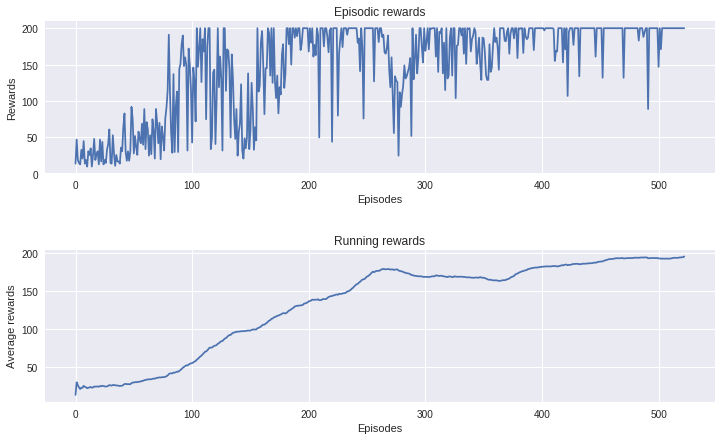

In [5]:
plot_rewards(rewards, running_rewards)

## Play some episodes
Play some episodes using out trained policy.

In [6]:
play_episodes(10)

Episode 1 finished with reward 200.0
Episode 2 finished with reward 200.0
Episode 3 finished with reward 200.0
Episode 4 finished with reward 200.0
Episode 5 finished with reward 200.0
Episode 6 finished with reward 200.0
Episode 7 finished with reward 200.0
Episode 8 finished with reward 200.0
Episode 9 finished with reward 200.0
Episode 10 finished with reward 200.0


## References
1. https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#reinforce
2. https://github.com/openai/gym/wiki/CartPole-v0
